In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import torch
import matplotlib.pyplot as plt

import pickle
import yaml
import numpy as np
from RetaredHarmonicDynamics import animate_particle
from matplotlib import animation
from scipy.stats import moment
from scipy.special import factorial, lambertw, erf
from pathlib import Path

tensor = torch.tensor

from my_functions import get_pos, get_mean_std, FokkerPlankCalculator, time_delayed_harmonic, damped_harmonic_oszillator
from my_functions import get_approx_freq,get_zero, get_pos_with_border, plot_bullerjahn_analysis

pic_path = Path('Graphic_Results/')

In [3]:
save_run = False

In [4]:
forces = {
    "no": lambda i: 0,
    "const": lambda i:2e-3,
    "ramp": lambda i: 0.005*i/(max_t),
    "oszi": lambda i: 0.005*np.cos(i * 10)
}

# No Froce

In [5]:
with open('std_parameter_setting.yaml') as f:
    std_parameter_setting = yaml.load(f , Loader=yaml.SafeLoader)
num_res_folder = Path('nummeric_results')/std_parameter_setting['name']
num_res_folder.mkdir(exist_ok=True)

# Geiss paper

# num_particle = 10000
# max_t = 2
# dt = 2e-4

# tau = 0.1
# k = 1
# border = 5e-6
# D = 1e-12

num_particle = std_parameter_setting['num_particle']
max_t = std_parameter_setting['max_t']
dt = std_parameter_setting['dt']

tau = std_parameter_setting['tau']
k =  std_parameter_setting['k']
border = std_parameter_setting['border']

D = float(std_parameter_setting['D'])

print(3*k*tau/2)
if 3*k*tau/2 < 1/np.e:
    print('decay regim')
elif 3*k*tau/2 < np.pi/2:
    print('damped oszillations')
else:
    print('diverging')
    
# print(20 * tau, 'max calculatable time') -> old is adjusted on the fly

1.5
damped oszillations


In [6]:
def plot_simulated_rate(
    k,
    tau,
    D,
    border,
    dt,
    num_particle,
    max_t,
    F=lambda i:0,
    safe_name=None):
    
    pos = get_pos_with_border(
        border = border,
        num_particle=num_particle,
        max_t = max_t,
        dt = dt,
        tau=tau,
        k=k,
        D=D,
        F=F)
    
    time = np.linspace(0,max_t,len(pos))
    particles = (~pos.isnan()).sum(1)

    fig, axs = plt.subplots(1,2, figsize=(9,4))
    axs[0].plot(time,particles)
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Number of particles')

    p_diff_raw = particles.diff(dim=0)*1.
    p_diff = p_diff_raw.clone()

    mean_bin = 50
    p_diff = p_diff.squeeze()
    p_diff = torch.stack([p_diff.repeat(mean_bin,1).diag(i).mean() 
                          for i in range(len(p_diff)-mean_bin)])
    p_diff = p_diff.unsqueeze(1)
    
    time_s = time[mean_bin//2:-mean_bin//2-1]
    
    
    axs[1].plot(time[:-1],p_diff_raw, alpha=0.2, label='raw')
    axs[1].plot(time_s,p_diff, label='smoothed')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Change of number of particles')
    axs[1].legend()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    if safe_name:
        plt.savefig(pic_path/f'{safe_name}_particles.pdf')
    plt.show()
    
    rate_raw = -p_diff_raw/particles[1:]/dt
    
    rate = -p_diff/particles[1+mean_bin//2:-mean_bin//2]/dt
    
    plt.plot(time[:-1],rate_raw, alpha=0.2)
    plt.plot(time_s,rate)
    average = 500
    print(rate_raw[-average:].mean(), 1/np.sqrt(average)*rate_raw[-average:].std())
    plt.xlabel("Time")
    plt.ylabel(r"Rate $\kappa$")
    if safe_name:
        plt.savefig(pic_path/f'{safe_name}_rate.pdf')
    plt.show()
    return pos, particles,rate, time, time_s

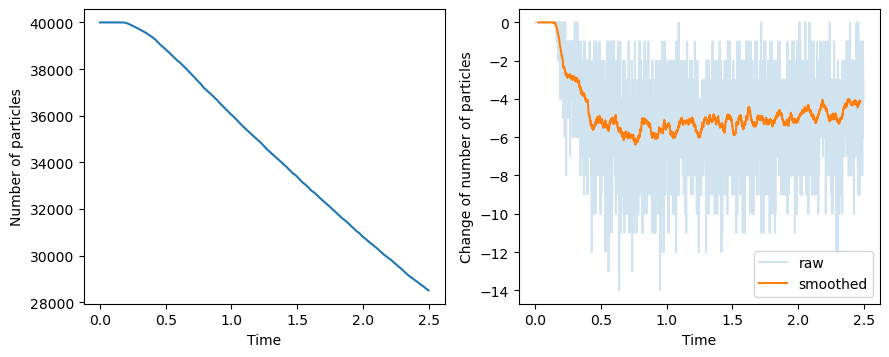

tensor(0.1548) tensor(0.0031)


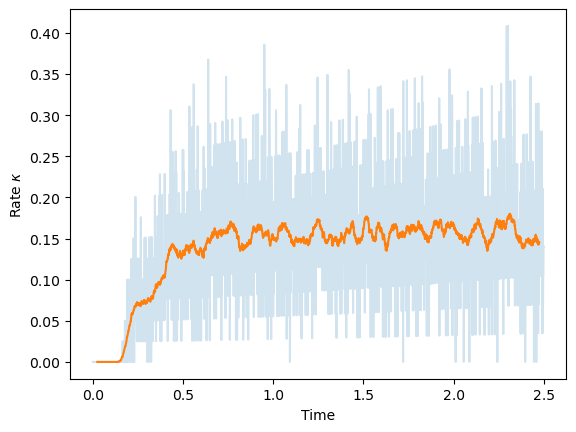

In [7]:
pos, particles_no_force, rate_no_force, time_no_force, time_no_force_s = plot_simulated_rate(
    tau=tau,
    k=k,
    D=D,
    num_particle=num_particle,
    dt=dt,
    border=border,
    max_t=max_t,
    F=forces['no'],
    safe_name='no_force')

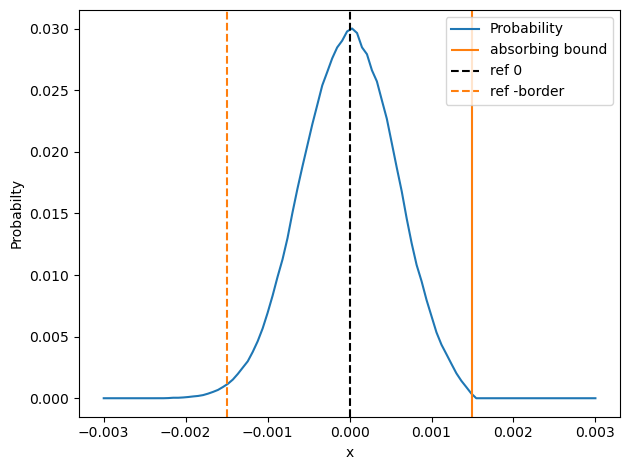

In [8]:
average = 50
xlim = (-3e-3,3e-3)
#xlim = (-1e-5,1e-5)
num_bins = 100
values = pos[-average:,:,0].flatten()
hist = values[~values.isnan()].float().histc(bins=num_bins, min=xlim[0], max=xlim[1], )/num_particle/average

plt.plot(np.linspace(*xlim,num_bins),hist, label='Probability')
plt.ylim(*plt.ylim())
plt.vlines(border,*plt.ylim(), label='absorbing bound', color='C1')
plt.vlines(0,*plt.ylim(), ls='--', color='black', label='ref 0')
plt.vlines(-border,*plt.ylim(), ls='--', label='ref -border', color='C1')

#plt.xlim(-1.5e-3, 1.5e-3)
#plt.ylim(1e-5,1e-1)
#plt.yscale('log')

plt.xlabel('x')
plt.ylabel('Probabilty')

plt.legend()
plt.tight_layout()

# Constant Force

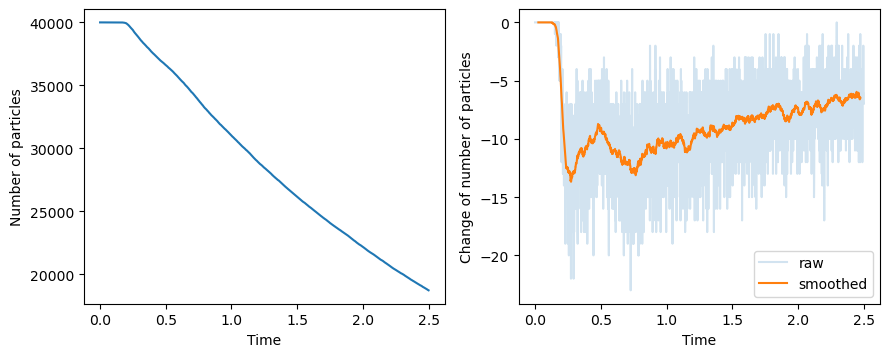

tensor(0.3375) tensor(0.0055)


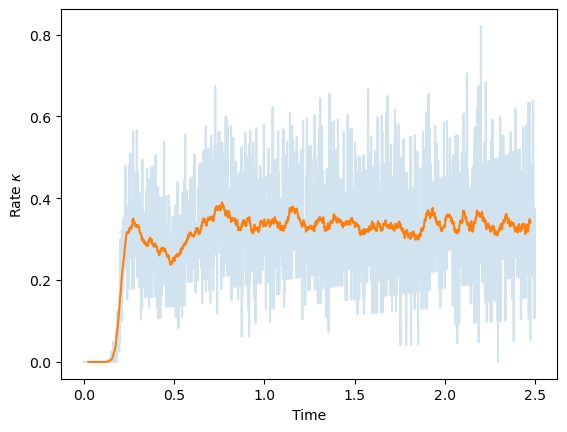

In [9]:
pos, particles_const,rate_const, time_const, time_const_s = plot_simulated_rate(
    k=k,
    tau=tau,
    D=D,
    num_particle=num_particle,
    border=border,
    F= forces['const'],
    max_t=max_t,
    dt=dt,
    safe_name='const_force')
    
#if torch.__version__ != '1.9.1':
#    plt.plot(pos.nanmean(dim=1))

# Force Ramp

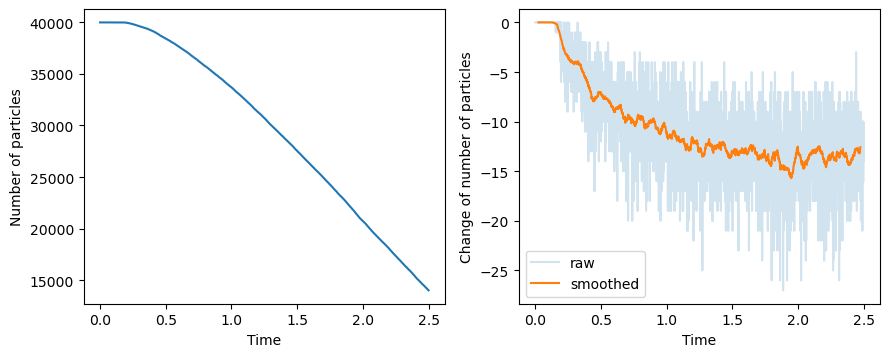

tensor(0.7849) tensor(0.0101)


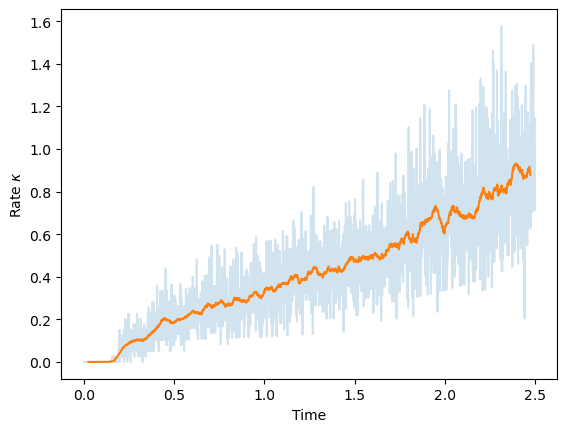

In [10]:
pos,particles_ramp, rate_ramp, time_ramp, time_ramp_s = plot_simulated_rate(
    k=k,
    tau=tau,
    D=D,
    num_particle=num_particle,
    border=border,
    F= forces['ramp'],
    max_t = max_t,
    dt = dt,
    safe_name='force_ramp')

#if torch.__version__ != '1.9.1':
#    plt.plot(pos.nanmean(dim=1))

# Oszillatory Force

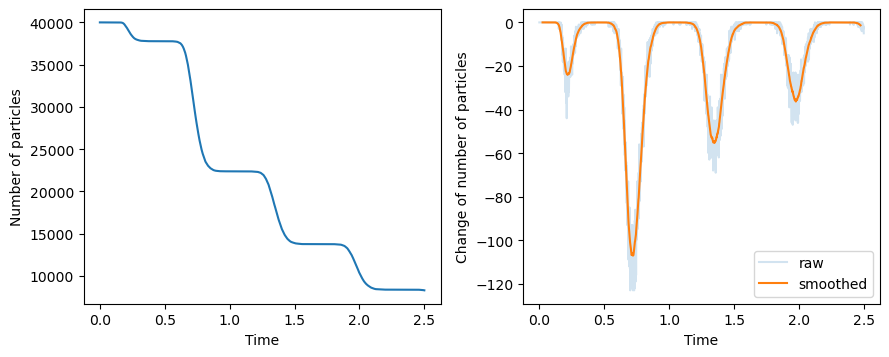

tensor(0.4399) tensor(0.0374)


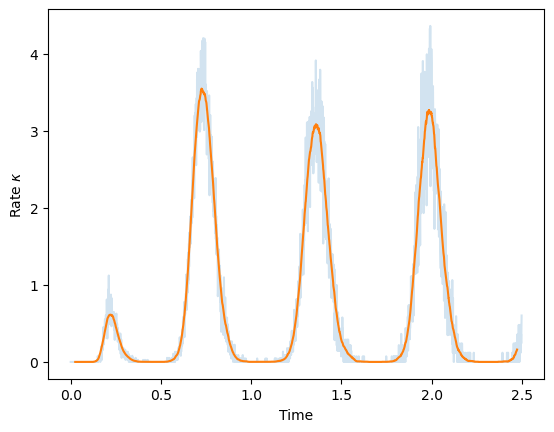

In [11]:
pos, particles_oszi,rate_oszi, time_oszi, time_oszi_s = plot_simulated_rate(
    k=k,
    tau=tau,
    D=D,
    num_particle=num_particle,
    border=border,
    F= forces['oszi'],
    max_t = max_t,
    dt=dt,
    safe_name='oszi_force')

#if torch.__version__ != '1.9.1':
#    plt.plot(pos.nanmean(dim=1))

# Bullerjahn

In [12]:
sim_res = {
    "no": rate_no_force,
    "const": rate_const,
    "ramp": rate_ramp,
    "oszi": rate_oszi
}

sim_res_num = {
    "no": particles_no_force/num_particle,
    "const": particles_const/num_particle,
    "ramp": particles_ramp/num_particle,
    "oszi": particles_oszi/num_particle
}
sim_res_abs = sim_res
# %store sim_res_abs
with open(num_res_folder/'sim_res_abs.pkl','wb') as f:
    pickle.dump(sim_res_abs, f)

In [13]:
len(time_ramp)

2500

26
1250


/home/nils/Programmieren/overdampedDelayHarmonicOscillator/my_functions.py:395: RuntimeWarning: divide by zero encountered in divide
  j = -(w*b-G-d_prefactor*D_t*(b-mu)/var) * 1 / np.sqrt(2*np.pi*var) * np.exp(-(b-mu)**2/(2*var))
/home/nils/Programmieren/overdampedDelayHarmonicOscillator/my_functions.py:395: RuntimeWarning: invalid value encountered in multiply
  j = -(w*b-G-d_prefactor*D_t*(b-mu)/var) * 1 / np.sqrt(2*np.pi*var) * np.exp(-(b-mu)**2/(2*var))
/home/nils/Programmieren/overdampedDelayHarmonicOscillator/my_functions.py:397: RuntimeWarning: divide by zero encountered in divide
  S = 1/2*(1+erf( (b-mu)/np.sqrt(2*var)))
/home/nils/Programmieren/overdampedDelayHarmonicOscillator/my_functions.py:407: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axs[0,0].set_ylim(0.9*np.sort(G)[11], 1.1*np.sort(G)[-11])


1250
1250
1250


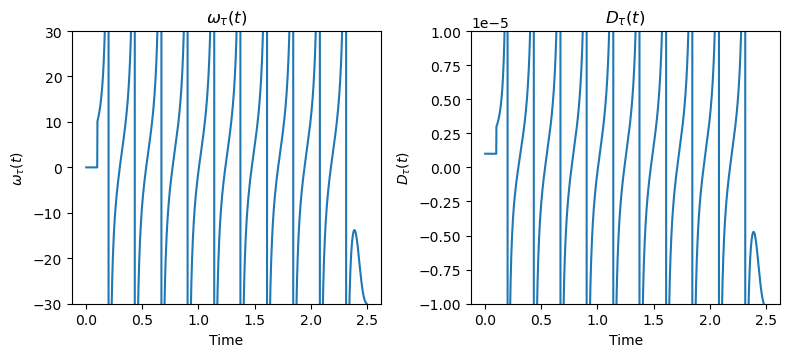

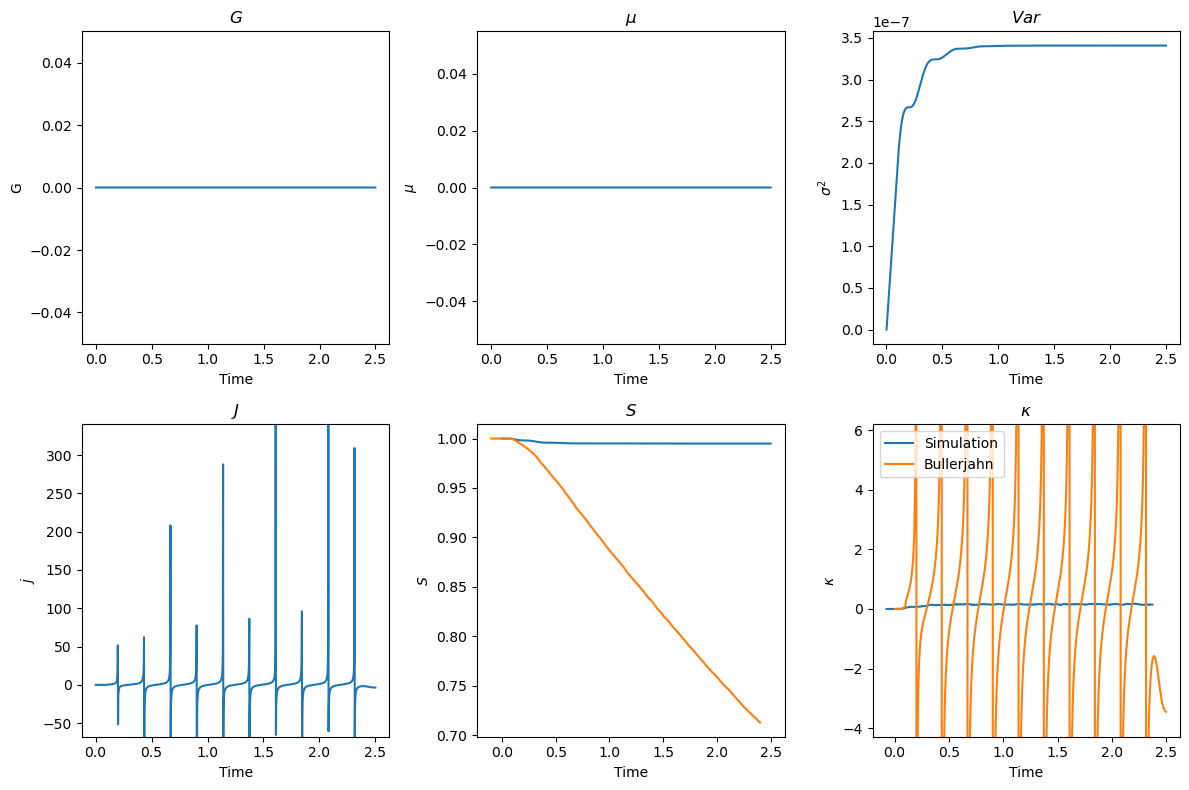

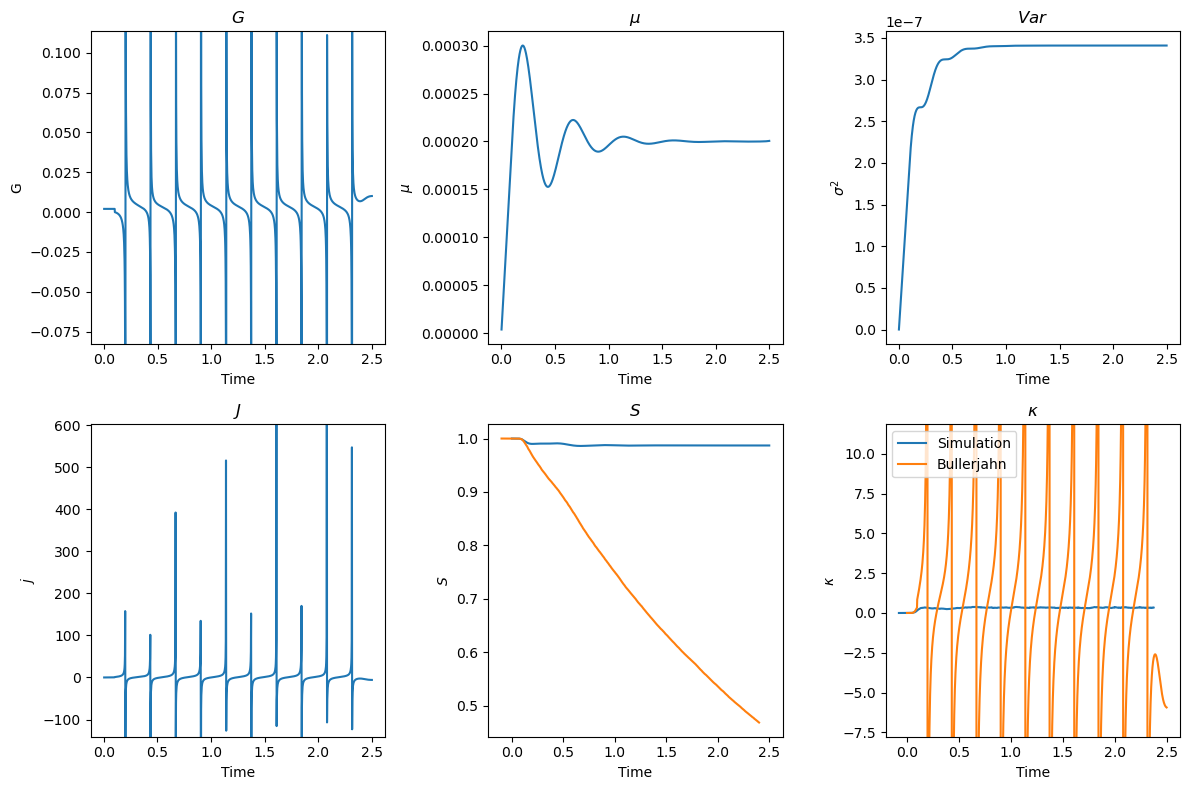

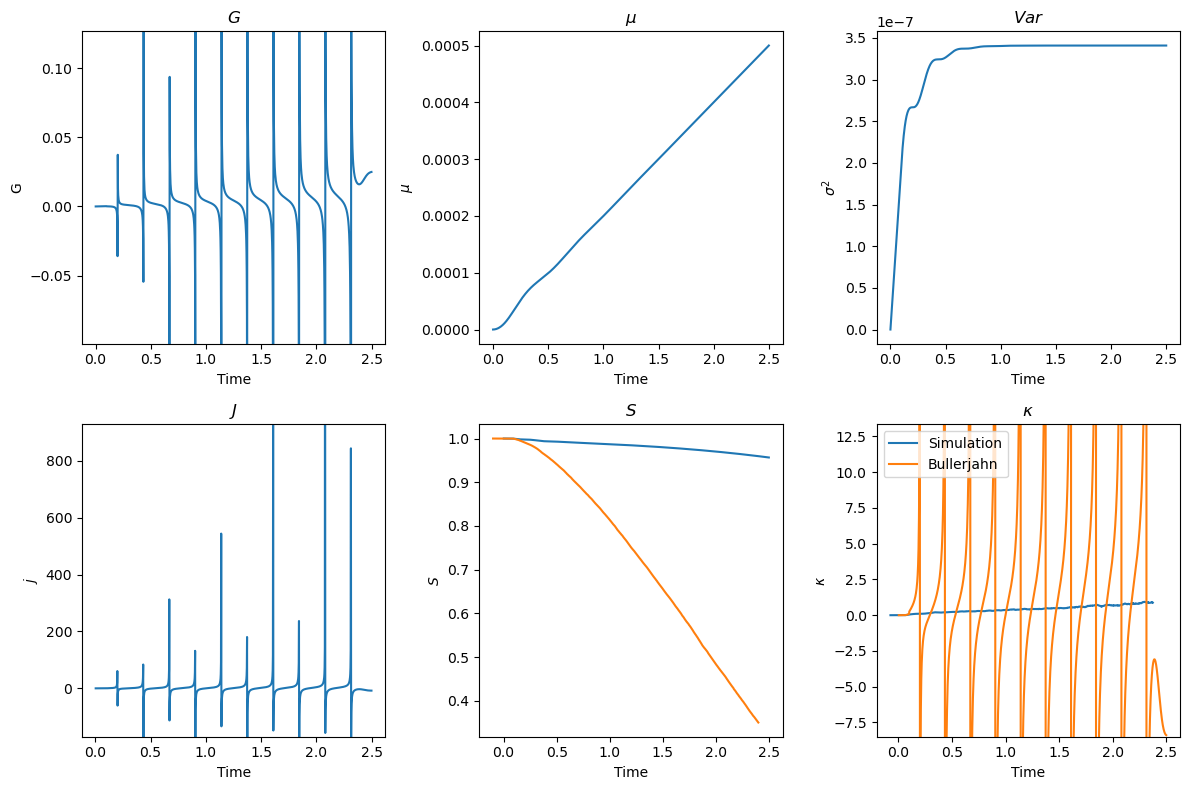

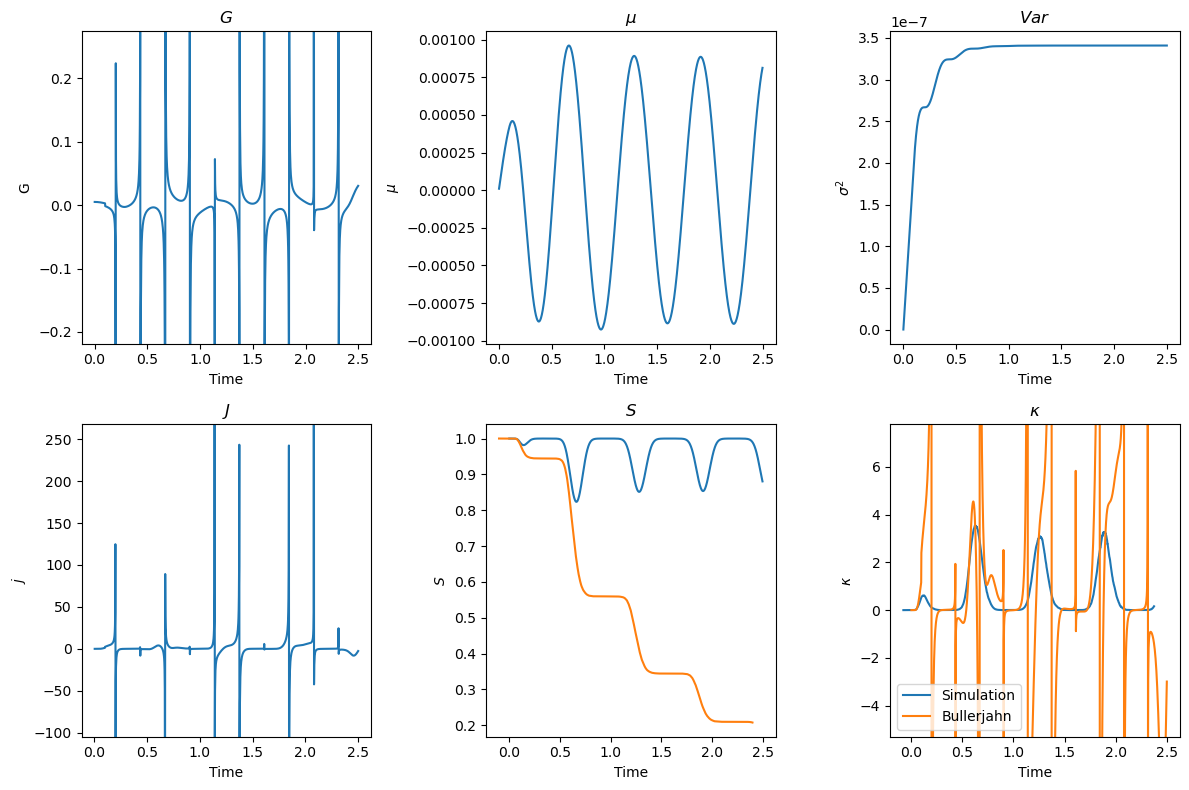

In [15]:
bullerjahn = plot_bullerjahn_analysis(max_t, dt, tau, k, D,border,
                                      time_ramp_s, sim_res,time_ramp,
                                      sim_res_num, forces,
                                      save_run, use_eq_D = False)

with open(num_res_folder/'bullerjahn.pkl', 'wb') as f:
    pickle.dump(bullerjahn, f)